# Assignment 2

## Part 1

In part 1, we will be analyzing the genres and communities of the country musicians network. We will be looking at the modularity of the network first, trying to partition the network correctly.

First, what is modularity? Modularity is a measure used to see how community-like a network, or part of a network, is. We calculate it by looking at the network's edges and nodes, and seeing which communities they belong to. The modularity can then tell us to what degree the network can be partitioned into communities, and whether or not there is a community-like pattern in the network. We calculate it using this equation:

$M = \sum_{c=1}^{n_{c}} [\frac{L_c}{L} - (\frac{k_c}{2L})^2]$

where $c$ is the current community, $n_c$ is the amount of communities, $L_c$ is the amount of links in the community, $L$ is the amount of links in the whole network, and $k_c$ is the average degree of the community.

As we've now explained the modularity measure, let's start setting up the network and laying the groundwork to calculate the modularity.

First we need to gather all the genres together for all the performers. Luckily, we've received a txt file containing this information, where each performer has a list of genres from their wikipedia articles.

In [34]:
import json
import re
import os
import networkx as nx
import unicodedata
all_genres_file = open("artists_genres_dictionary.txt",encoding='utf-8')
all_genres = json.load(all_genres_file)

We can now create the network, remembering to sanitize the titles for txt files. We want to check if we have the genres for each performer, otherwise we can simply skip that performer:

In [35]:
G_country = nx.DiGraph()
all_performers = os.listdir("performers_pages")

for file_title in all_performers:
    #Sanitize the file name
    file_title_san = file_title.replace(".txt", "")
    #Get name of performer
    performer_name = file_title_san.replace("_"," ")
    #Check if performer is in our dictionary of genres
    if performer_name in all_genres:
        # Find their wiki in the folder of performers
        file = open('performers_pages/' + file_title,encoding='utf-8')
        file_content = file.read()
        content_length = len(file_content.split())
        wiki_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]',file_content)
        #Add as a node, containing the length of the article and their first genre as characteristics
        G_country.add_node(file_title_san,length_of_content=content_length,genre = all_genres[performer_name][0])
        #Linking the nodes to other nodes, creating some new nodes in the process
        for link,_ in wiki_links:
            link_title = link.replace(' ', '_')
            link_title = re.sub(r'[\/:*?"<>|]', '_', link_title)
            link_title = unicodedata.normalize('NFKD', link_title).encode('ascii', 'ignore').decode('ascii')
            link_name = link_title.replace("_"," ")
            #Checking again if performers are in the dictionary of genres
            if link_title+".txt" in all_performers and link_name in all_genres:
                G_country.add_edge(file_title_san,link_title)
#Remove isolated nodes
isolated = [node for node in G_country.nodes if G_country.degree(node) == 0]
G_country.remove_nodes_from(isolated)
#Look at the largest component of the network
largest_component = max(nx.weakly_connected_components(G_country), key=len)
G = G_country.subgraph(largest_component).copy()
#Change directed graph to undirected
G_undir = G.to_undirected()

We've now created the network. We can then try to do our own partitioning of the network, based on genres:

In [36]:
genre_partition = {}
genres = nx.get_node_attributes(G_undir,"genre")
for node, data in G_undir.nodes(data=True):
    genre = data['genre']  # First genre in the performer's list
    if genre not in genre_partition:
        genre_partition[genre] = []
    genre_partition[genre].append(node)

Let's now try to calculate the modularity using our partition:

In [37]:
communities = list(genre_partition.values())
def modularity_measure(G_undir, communities):
    L = G_undir.size()
    modularity = 0
    for community in communities:
        G_community = G_undir.subgraph(community)
        L_c = G_community.size()
        k_c = sum(dict(G_undir.degree(community)).values())
        modularity += (L_c/L) - (k_c/(2*L))**2
    return modularity

print(modularity_measure(G_undir,communities))
    

0.07061860613048114


Here we can see that the modularity is positive but not very high, meaning not a lot of modularity or community structure. Currently, most of the artists are country artists, so let's try choosing their second genre instead.

In [38]:
G_country = nx.DiGraph()
all_performers = os.listdir("performers_pages")

for file_title in all_performers:
    #Sanitize the file name
    file_title_san = file_title.replace(".txt", "")
    #Get name of performer
    performer_name = file_title_san.replace("_"," ")
    #Check if performer is in our dictionary of genres
    if performer_name in all_genres:
        # Find their wiki in the folder of performers
        file = open('performers_pages/' + file_title,encoding='utf-8')
        file_content = file.read()
        content_length = len(file_content.split())
        wiki_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]',file_content)
        
        # Add as a node, containing the length of the article and their SECOND genre as characteristics
        #Default to first genre if there isn't enough genres
        performer_genre = all_genres[performer_name][0]
        if "country" in all_genres[performer_name] and len(all_genres[performer_name]) > 1:
            for genre in all_genres[performer_name]: 
                if genre != "country":
                    performer_genre = genre
        G_country.add_node(file_title_san,length_of_content=content_length,genre = performer_genre)
 
        #Linking the nodes to other nodes, creating some new nodes in the process
        for link,_ in wiki_links:
            link_title = link.replace(' ', '_')
            link_title = re.sub(r'[\/:*?"<>|]', '_', link_title)
            link_title = unicodedata.normalize('NFKD', link_title).encode('ascii', 'ignore').decode('ascii')
            link_name = link_title.replace("_"," ")
            #Checking again if performers are in the dictionary of genres
            if link_title+".txt" in all_performers and link_name in all_genres:
                G_country.add_edge(file_title_san,link_title)
#Remove isolated nodes
isolated = [node for node in G_country.nodes if G_country.degree(node) == 0]
G_country.remove_nodes_from(isolated)
#Look at the largest component of the network
largest_component = max(nx.weakly_connected_components(G_country), key=len)
G = G_country.subgraph(largest_component).copy()
#Change directed graph to undirected
G_undir = G.to_undirected()

We can try to calculate the modularity again, after partitioning:

In [39]:
genre_partition = {}
genres = nx.get_node_attributes(G_undir,"genre")
for node, data in G_undir.nodes(data=True):
    genre = data['genre'] #Second genre in genre list 
    if genre not in genre_partition:
        genre_partition[genre] = []
    genre_partition[genre].append(node)
communities = list(genre_partition.values())
print(modularity_measure(G_undir,communities))

0.06465620807739869


This is positive modularity, but still not a very high modularity, meaning the partition is sub-optimal, and we can't correctly find communities based on the genre partitioning. In fact, the modularity is lower than before. This might show that by choosing the second genre, more nodes are "isolated", since they might be the only ones with that genre, thus creating more isolated, smaller communities and a lower modularity.

We can see that the partitioning based on the genres didn't really show much modularity. We can try to use the Python Louvain-algorithm implementation to try and obtain a better partitioning:

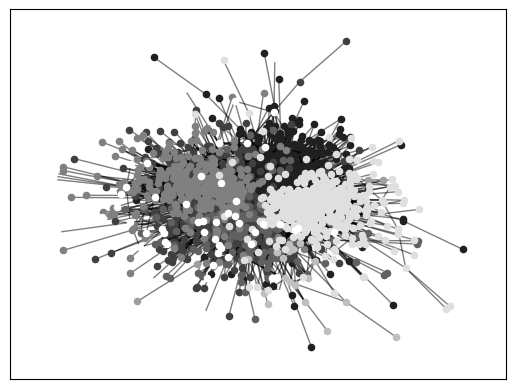

In [40]:
import community
import networkx as nx
import matplotlib.pyplot as plt
G_undir = G.to_undirected()
partition = community.best_partition(G_undir)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_undir)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G_undir, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G_undir,pos, alpha=0.5)
plt.show()

What is the modularity of this partitioning? The community package has it's own modularity function, which we can use:

In [41]:
community.modularity(partition,G_undir)

0.38784058048326225

The modularity is much higher here, showing that there is some kind of community patterns in the network, not necessarily based entirely on genre, but some other elements of the network. This could be social grouping, where people group together if they know each other. What we see is a network that is more community-like than the genre partioning showed. 

Plotting the network with these communities, using ForceAtlas2, can show us how well this modularity and partitioning represents the network:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:35<00:00, 21.05it/s]


BarnesHut Approximation  took  17.52  seconds
Repulsion forces  took  74.19  seconds
Gravitational forces  took  0.26  seconds
Attraction forces  took  0.58  seconds
AdjustSpeedAndApplyForces step  took  1.13  seconds


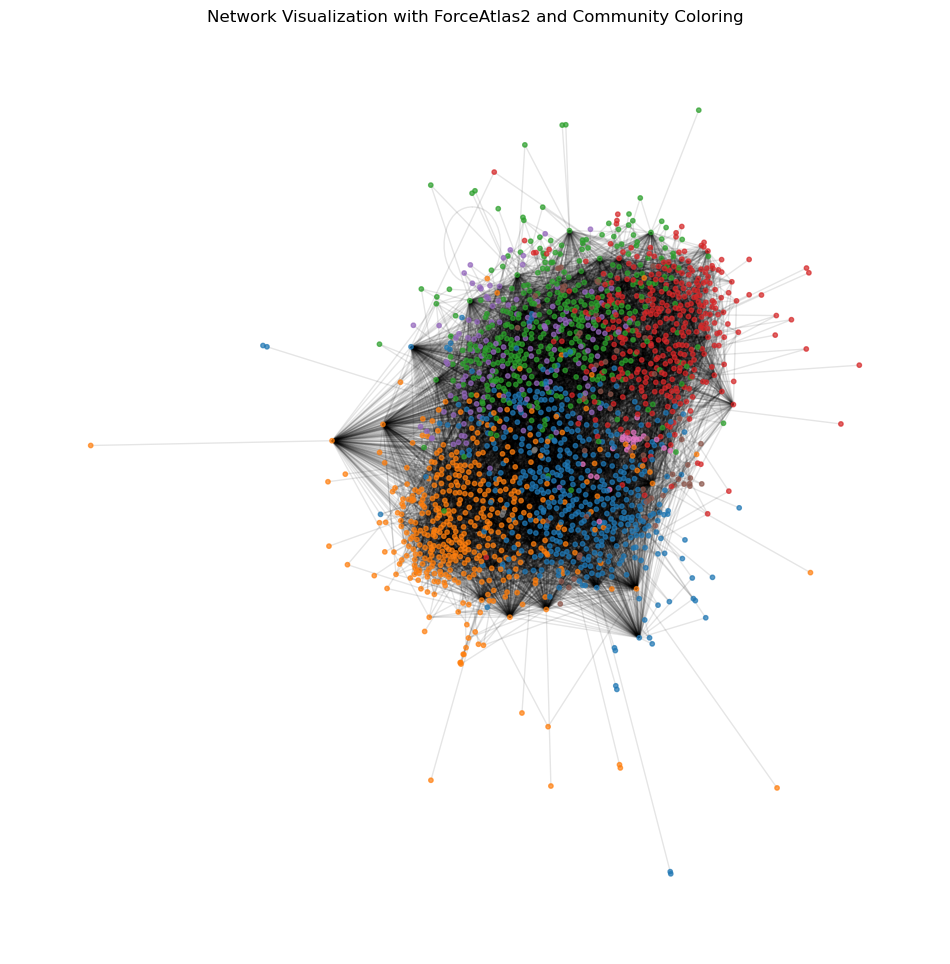

In [42]:
from fa2_modified import ForceAtlas2
import community
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=2000)

community_sizes = {}
for node, com in partition.items():
    if com not in community_sizes:
        community_sizes[com] = 0
    community_sizes[com] += 1

top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)
colors = list(mcolors.TABLEAU_COLORS.keys())
community_color_map = {com: colors[i % len(colors)] for i, com in enumerate(top_communities)}
neutral_color = "lightgray"

node_colors = [
    community_color_map.get(partition[node], neutral_color) for node in G_undir.nodes()
]

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_undir, positions, node_color=node_colors, node_size=10, alpha=0.7)
nx.draw_networkx_edges(G_undir, positions, edge_color="black", alpha=0.1)

plt.title("Network Visualization with ForceAtlas2 and Community Coloring")
plt.axis("off")
plt.show()

We can see that each "corner" of the structure is its own big community, meaning we have 4 big communities. There are also small communities mixed in within the structure. These smaller communities have some level of structure, either by closeness or some links connecting them across the network. For example, one of the communities is spacially mixed, having nodes of two communities next to each other. These may link together in ways, causing them to be partitioned into two different communities, even though they positionally are closer to each other.

We've now looked at what happens if we only choose one genre. What if we choose the full list for each performer, and try to make a confusion matrix out of the network?

In [43]:
G_country = nx.DiGraph()
all_performers = os.listdir("performers_pages")

for file_title in all_performers:
    #Sanitize the file name
    file_title_san = file_title.replace(".txt", "")
    #Get name of performer
    performer_name = file_title_san.replace("_"," ")
    #Check if performer is in our dictionary of genres
    if performer_name in all_genres:
        # Find their wiki in the folder of performers
        file = open('performers_pages/' + file_title,encoding='utf-8')
        file_content = file.read()
        content_length = len(file_content.split())
        wiki_links = re.findall(r'\[\[([^\|\]]+)(\|[^\]]+)?\]\]',file_content)

        #Add the performer as node, with content length and list of genres as characteristics
        performer_genre = all_genres[performer_name]
        G_country.add_node(file_title_san,length_of_content=content_length,genre = performer_genre)
        
        #Linking the nodes to other nodes, creating some new nodes in the process
        for link,_ in wiki_links:
            link_title = link.replace(' ', '_')
            link_title = re.sub(r'[\/:*?"<>|]', '_', link_title)
            link_title = unicodedata.normalize('NFKD', link_title).encode('ascii', 'ignore').decode('ascii')
            link_name = link_title.replace("_"," ")
            #Checking again if performers are in the dictionary of genres
            if link_title+".txt" in all_performers and link_name in all_genres:
                G_country.add_edge(file_title_san,link_title)
#Remove isolated nodes
isolated = [node for node in G_country.nodes if G_country.degree(node) == 0]
G_country.remove_nodes_from(isolated)
#Look at the largest component of the network
largest_component = max(nx.weakly_connected_components(G_country), key=len)
G = G_country.subgraph(largest_component).copy()
#Change directed graph to undirected
G_undir = G.to_undirected()

We can now try to construct the confusion matrix, for the top 7 genres and communities:

In [44]:
import numpy as np
import pandas as pd
from collections import Counter
import community
import networkx as nx
import matplotlib.pyplot as plt

partition = community.best_partition(G_undir)

node_genres = nx.get_node_attributes(G_undir,"genre")
all_genres = [genre for genres in node_genres.values() for genre in genres]

# Step 1: Identify the top 7 genres and top 7 communities
genre_counts = Counter(all_genres)
top_genres = [genre for genre, _ in genre_counts.most_common(7)]

community_counts = Counter(partition.values())
top_communities = [community for community, _ in community_counts.most_common(7)]

# Create mappings for genre and community indices
genre_to_index = {genre: i for i, genre in enumerate(top_genres)}
community_to_index = {community: j for j, community in enumerate(top_communities)}

# Step 2: Initialize the confusion matrix D with dimensions 7x7
D = np.zeros((7, 7), dtype=int)

# Step 3: Populate the confusion matrix
for node, genres in node_genres.items():
    community = partition.get(node)
    
    if community in community_to_index:
        j = community_to_index[community]
        # Check if the node's genre and community are in the top 7
        for genre in genres:
            if genre in genre_to_index:
                i = genre_to_index[genre]
                D[i, j] += 1
                
# Convert the matrix to a DataFrame for easier viewing
confusion_df = pd.DataFrame(D, index=top_genres, columns=top_communities)

# Display the confusion matrix
print("Confusion Matrix (Genre vs Community):")
print(confusion_df)


Confusion Matrix (Genre vs Community):
                1    2    5    4   0   3  6
country       462  352  359  172  84  53  6
folk           19   10   29   88  31   1  0
country rock   33   48   21   53   5   4  6
americana      20   12   14   88  16   1  5
pop            26   51   45   24   4   3  0
bluegrass      24    9    8   21  65   0  0
rock           23   20   18   44   6   3  1


We can see that the communities don't really correspond to genres. Most of them seem to have country music as the most popular genre, which makes sense, as this is a network of country performers. Even the second most popular genre doesn't really give us a direction for each community, as they are very close.

This might show us that within these genres, communities have shaped differently. Perhaps this might be groups that collaborate often, or are more inspired by each other, than other parts of the network, thus creating a community based partly on genres but also on the social aspect of which performers perform with each other or are inspired across groups.